# Local Model Training

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from model import get_dataloaders

import matplotlib.pyplot as plt

from model import FederatedCNN


100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


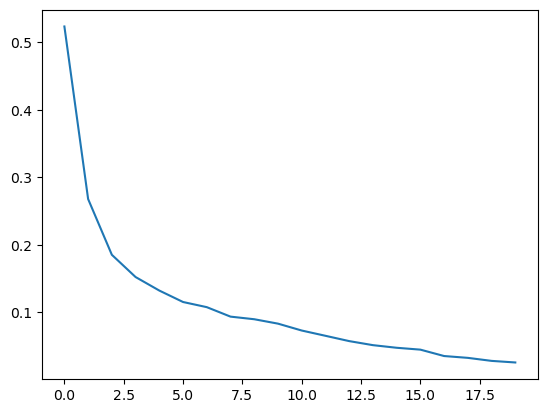

In [2]:
SRC_PATH = "./resources/pneumoniamnist.npz"


model = FederatedCNN(in_channels=1, num_classes=1)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)
ce_loss = nn.BCEWithLogitsLoss()

train_dl, test_dl = get_dataloaders(SRC_PATH)

train_metrics, test_metrics = model.train_model(
    epochs=20,
    optimizer=optimizer,
    criterion=ce_loss,
    train_loader=train_dl,
    test_loader=test_dl
)

plt.plot(train_metrics["loss"])


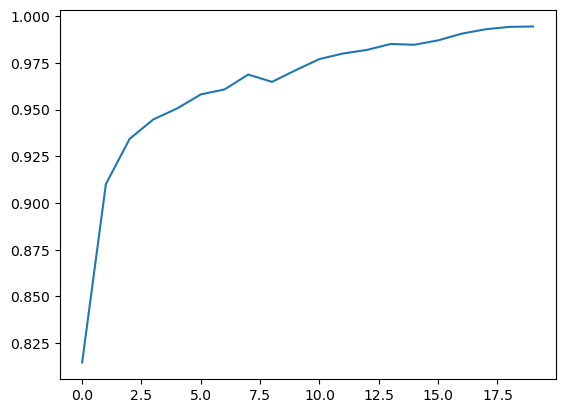

In [3]:
plt.plot(train_metrics["acc"])

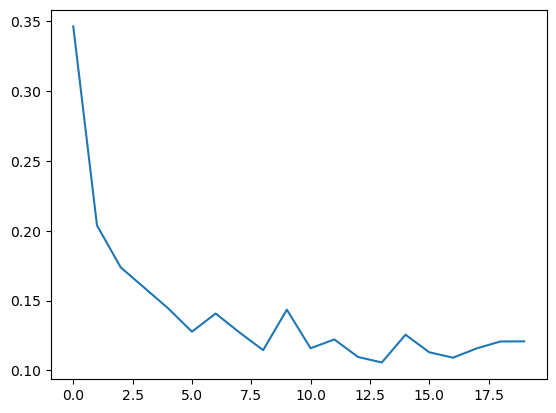

In [4]:
plt.plot(test_metrics["loss"])

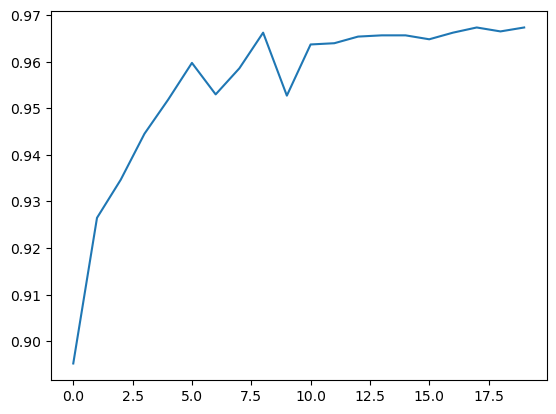

In [5]:
plt.plot(test_metrics["acc"])

# Federated Model Training

## Split Data for Federated Learning

In [6]:
import numpy as np
from model.dataset import read_medmnist

SRC_PATH = "./resources/pneumoniamnist.npz"
CLIENTS = 4  # Number of federated clients

data, labels = read_medmnist(SRC_PATH)
print(f"Shape of data: {data.shape} and shape of labels: {labels.shape}")


Shape of data: (5856, 28, 28) and shape of labels: (5856, 1)


In [7]:
l_data, l_labels = np.split(data, CLIENTS), np.split(labels, CLIENTS)
for client in range(CLIENTS):
    np.savez(f"./resources/pneumoniamnist_client{client}.npz", images=l_data[client], labels=l_labels[client])
    print("saved client data for client", client)

saved client data for client 0
saved client data for client 1
saved client data for client 2
saved client data for client 3


In [8]:
data, labels = read_medmnist("./resources/pneumoniamnist_client0.npz")
print(f"Shape of data: {data.shape} and shape of labels: {labels.shape}")

Shape of data: (1464, 28, 28) and shape of labels: (1464, 1)


In [10]:
def train_client(client, epochs=50, lr=0.001, momentum=0.7):
    model = FederatedCNN(in_channels=1, num_classes=1)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    ce_loss = nn.BCEWithLogitsLoss()

    train_dl, test_dl = get_dataloaders(f"./resources/pneumoniamnist_client{client}.npz")

    train_metrics, test_metrics = model.train_model(
        epochs=epochs,
        optimizer=optimizer,
        criterion=ce_loss,
        train_loader=train_dl,
        test_loader=test_dl
    )

    return model, train_metrics, test_metrics


for client in range(CLIENTS):
    model, train_metrics, test_metrics = train_client(client)
    torch.save(model.state_dict(), f"./resources/pneumoniamnist_client{client}.pt")
    print("saved model for client", client)

100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


saved model for client 0


100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


saved model for client 1


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


saved model for client 2


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]

saved model for client 3


In [15]:


global_model = FederatedCNN(in_channels=1, num_classes=1)

params =  []
for client in range(CLIENTS):
    cl_model = FederatedCNN(in_channels=1, num_classes=1)
    cl_model.load_state_dict(torch.load(f"./resources/pneumoniamnist_client{client}.pt"))
    cl_params = cl_model.get_parameters()

params_avg = [sum(p) / len(p) for p in zip(params)]

# Update the parameters of one of the models
with torch.no_grad():
    for model_params, avg_params in zip(global_model.parameters(), params_avg):
        model_params.data.copy_(avg_params)

100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


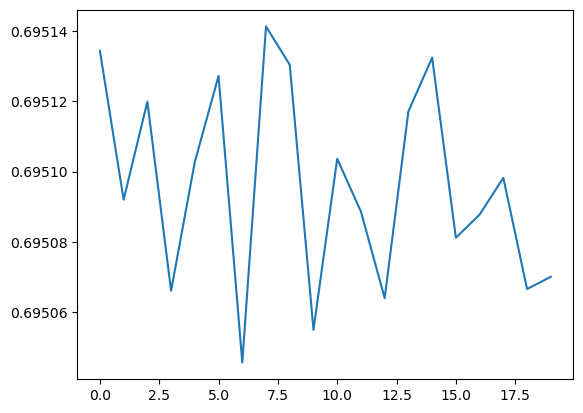

In [16]:
SRC_PATH = "./resources/pneumoniamnist.npz"

optimizer = optim.SGD(global_model.parameters(), lr=0.001, momentum=0.7)
ce_loss = nn.BCEWithLogitsLoss()

train_dl, test_dl = get_dataloaders(SRC_PATH)

train_metrics, test_metrics = global_model.train_model(
    epochs=20,
    optimizer=optimizer,
    criterion=ce_loss,
    train_loader=train_dl,
    test_loader=test_dl,
    mode="eval",
)

plt.plot(test_metrics["loss"])


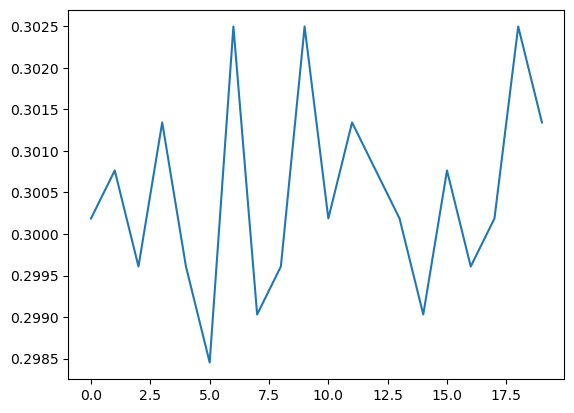

In [17]:
plt.plot(test_metrics["acc"])

In [14]:
[p for p in global_model.parameters()]

[Parameter containing:
 tensor([[[[-0.2190,  0.1040, -0.0416],
           [ 0.0647, -0.2948, -0.0346],
           [-0.2920,  0.1840, -0.1796]]],
 
 
         [[[-0.1779,  0.2621,  0.2720],
           [-0.2152,  0.3240, -0.2226],
           [-0.3270, -0.3109, -0.0125]]],
 
 
         [[[ 0.0709,  0.0276,  0.0557],
           [ 0.1293, -0.2837,  0.0064],
           [ 0.1832,  0.2923,  0.2691]]],
 
 
         [[[ 0.2360,  0.1291,  0.0875],
           [ 0.0521, -0.1911,  0.0412],
           [-0.0857, -0.0844, -0.1178]]],
 
 
         [[[ 0.0816, -0.1666, -0.1129],
           [-0.1447,  0.0461, -0.2415],
           [-0.1163,  0.0662,  0.2911]]],
 
 
         [[[-0.0822,  0.0387, -0.0240],
           [-0.1084,  0.2534, -0.2842],
           [ 0.2934,  0.0189,  0.1933]]],
 
 
         [[[ 0.0853,  0.2625,  0.2838],
           [ 0.2166, -0.1188,  0.2209],
           [ 0.1437, -0.0923, -0.0202]]],
 
 
         [[[-0.2924,  0.0631,  0.2641],
           [ 0.0184, -0.3252,  0.1618],
           [-0.